# What things are included in this Kernel ?

* Problem Statment and the Analysis of the Problem Statment
* Data Understanding
* Designing the Model
* Validation And Analysis
    * Metrics
    * Prediction and Activation Visualizations
    * ROC AND AUC
* Submission


# 1 

# a). Problem Statment

> ### Task - The problem is mainly a BINARY IMAGE CLASSIFICATION PROBLEM. The Problem focuses on identifying the presence of metastases from a 96 * 96 digital histopathology images

> ### Metric Evaluation - Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target. 

<img src='https://i.stack.imgur.com/kqxaJ.png' style="width:500px;height:300px;">


# b). Analysis of the problem Statment

> ## What Exactly the problem statment conveys to us?
> ### 1. The problem deals with the Binary Classification of the Image that has a shape of 96px * 96px. It involves identifying the metastases from the 96px * 96px digital histapathology images.

> ### 2. One key challenge is that the metastases can be as small as single cells in a large area of tissue.


### The Histopathological Images:

### About the Domain: 
Obviously, I do not know much about Biology,I made some notes about the following terminologies :
* Histopathology
* Lymphocytes
* Lymph Nodes

### So, let us see some of the biological terminologies involved 

### 1. Histopathology - Histopathology is the diagnosis and study of diseases of the tissues, and involves examining tissues and/or cells under a microscope. Histopathologists are responsible for making tissue diagnoses and helping clinicians manage a patient's care.

<img src = 'https://www.news-medical.net/image.axd?picture=2018%2F12%2FBy_Vshivkova-1.jpg' style="width:500px;height:300px;">


#

### 2. Lymphocytes - Lymphocytes are white blood cells that are also one of the body's main types of immune cells. They are made in the bone marrow and found in the blood and lymph tissue. The immune system is a complex network of cells known as immune cells that include lymphocytes.


<img src = 'https://healthmattersio.files.wordpress.com/2018/05/lymphocytes-healthmatters-io.png?w=1600&h=1200&crop=1' style="width:500px;height:300px;">


#
### 3. Lymph Nodes- Lymph nodes are small lumps of tissue that contain white blood cells, which fight infection. They filter lymph fluid, which is composed of fluid and waste products from your body tissues. Lymph nodes also help activate your immune system if you have an infection.




### So, now let us dive into the domain which involves Data Collection:


* #### The data that is provided to us for classification are the histopathological images. These images are glass slide microscope images of lymph nodes that are stained with hematoxylin and eosin (H&E). 
* #### Hematoxylin and eosin (H&E) is the most widely used stain in histology and allows localization of nuclei and extracellular proteins. Hematoxylin, not a dye itself, produces the blue Hematin via an oxidation reaction with nuclear histones causing nuclei to show blue. 
* #### Typically nuclei are stained blue, whereas cytoplasm and extracellular parts in various shades of pink.

* #### Lymph nodes are small glands that filter the fluid in the lymphatic system and they are the first place a breast cancer is likely to spread. 

* #### Histological assessment of lymph node metastases is part of determining the stage of breast cancer in TNM classification which is a globally recognized standard for classifying the extent of spread of cancer. 

### Links for Reference

* <a href='https://www.cancer.net/navigating-cancer-care/cancer-basics/what-metastasis'>What is Metastatis?</a>
* <a href='https://en.wikipedia.org/wiki/H%26E_stain'>Hematoxylin and eosin (H&E) Staining</a>
* <a href='https://www.medicalnewstoday.com/articles/320987#:~:text=Lymphocytes%20are%20white%20blood%20cells,immune%20cells%20that%20include%20lymphocytes.'>Lymphocytes</a>
* <a href='https://www.healthdirect.gov.au/lymph-nodes'>Lymph Nodes</a>
* <a href='https://en.wikipedia.org/wiki/TNM_staging_system'>TNM Classification</a>

# 2.  Data Understanding

* The dataset contains the histopathological Images, each image is 96px * 96px. 

* A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

* Kaggle says that :
                    'The original PCam dataset contains duplicate images due to its probabilistic sampling,
                    however, the version presented on Kaggle does not contain duplicates. We have otherwise 
                    maintained the same data and splits as the PCam benchmark.'
                   
* Also, one of the hing is that the problem states that the training Data contains **50/50** Images of both the labels i.e. the training contains equal proportion of both the labels, however on analysis it was found to be nearly equal to **60/40**, which we will consider while we design the model




* ### **IS DATA RELEVANT TO THE PROBLEM ?**
> This dataset is a combination of two independent datasets collected in Radboud University Medical Center (Nijmegen, the Netherlands), and the University Medical Center Utrecht (Utrecht, the Netherlands). The slides are produced by routine clinical practices and a trained pathologist would examine similar images for identifying metastases.

* ### So, now let us move forward to design our model

# 3. Designing the Model  (Coding Part)

In [1]:
# Importing  Libraries
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(101)

In [2]:
# Setting Some Pre-Requisites
IMAGE_SIZE=96
IMAGE_CHANNELS=3
SAMPLE_SIZE=80000         # We will be training 80,000 samples from each label

In [3]:
# So, what are the files which are available?

os.listdir('../input/histopathologic-cancer-detection')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [4]:
# So, how many images are there in each of the folder in the training dataset?

print(len(os.listdir('../input/histopathologic-cancer-detection/train')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test')))

220025
57458


In [5]:
# Creating a dataframe of all the training images

df_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

# removing this image because it caused a training error previously
df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


print(df_data.shape)

(220025, 2)


In [6]:
df_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [7]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

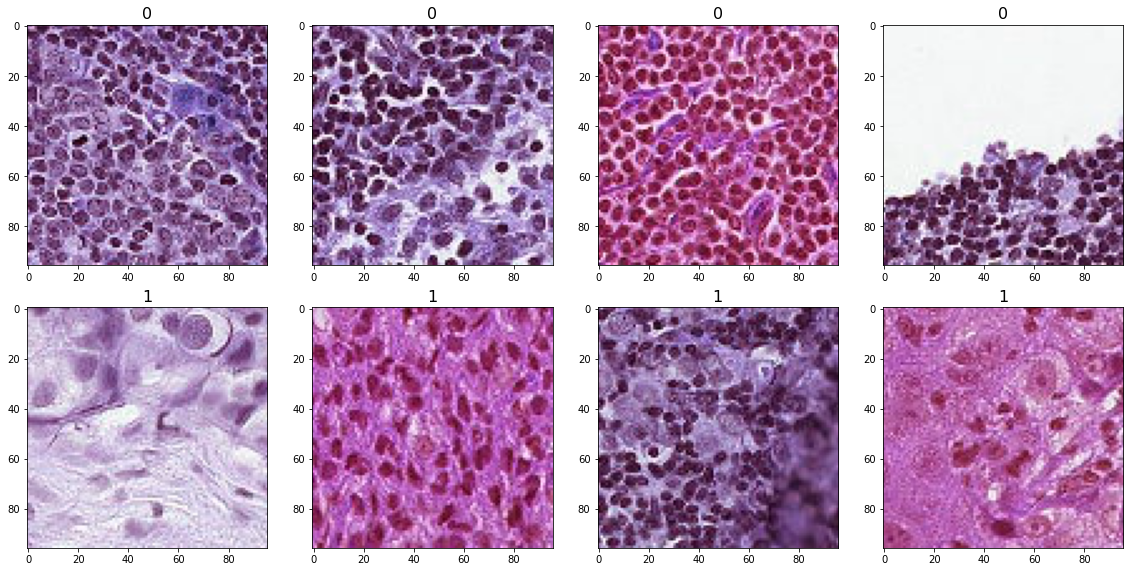

In [8]:
IMAGE_PATH = '../input/histopathologic-cancer-detection/train/' 

draw_category_images('label',4, df_data, IMAGE_PATH)

In [9]:
# Create the Train and Validation Sets

df_0=df_data[df_data['label']==0].sample(SAMPLE_SIZE,random_state=101)
df_1=df_data[df_data['label']==1].sample(SAMPLE_SIZE,random_state=101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [10]:
# Now, for the train-test split

# stratify=y creates a balanced validation set.
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(144000, 2)
(16000, 2)


In [11]:
# Create a new directory so that we will be using the ImageDataGenerator
base_dir='base_dir'
os.mkdir(base_dir)

# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue

# val_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue



# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

In [12]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

['b_has_tumor_tissue', 'a_no_tumor_tissue']

In [13]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

In [14]:
# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])



# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [15]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/train_dir/b_has_tumor_tissue')))

72000
72000


In [16]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/val_dir/b_has_tumor_tissue')))

8000
8000


In [17]:
# Set up the generators
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../input/histopathologic-cancer-detection/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [18]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


### The model that I have choosen for this problem has been taken from <a href = 'https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb'>Baseline Keras CNN</a>

In [19]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 64)        3

In [20]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [21]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}


In [22]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/20
14400/14400 [==============================] - 242s 17ms/step - loss: 0.4393 - accuracy: 0.7993 - val_loss: 0.3816 - val_accuracy: 0.8222
Epoch 2/20
14400/14400 [==============================] - 210s 15ms/step - loss: 0.3384 - accuracy: 0.8533 - val_loss: 0.3270 - val_accuracy: 0.8629
Epoch 3/20
14400/14400 [==============================] - 218s 15ms/step - loss: 0.2951 - accuracy: 0.8757 - val_loss: 0.3072 - val_accuracy: 0.8646
Epoch 4/20
14400/14400 [==============================] - 215s 15ms/step - loss: 0.2711 - accuracy: 0.8878 - val_loss: 0.2442 - val_accuracy: 0.9014
Epoch 5/20
14400/14400 [==============================] - 221s 15ms/step - loss: 0.2524 - accuracy: 0.8971 - val_loss: 0.2342 - val_accuracy: 0.9062
Epoch 6/20
14400/14400 [==============================] - 216s 15ms/step - loss: 0.2375 - accuracy: 0.9044 - val_loss: 0.2354 - val_accuracy: 0.9105
Epoch 7/20
14400/14400 [==============================] - 215s 15ms/step - loss: 0.2281 - accuracy: 0.9089

In [23]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [24]:
# Here the best epoch will be used.



val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.16548317670822144
val_acc: 0.9366250038146973


<Figure size 432x288 with 0 Axes>

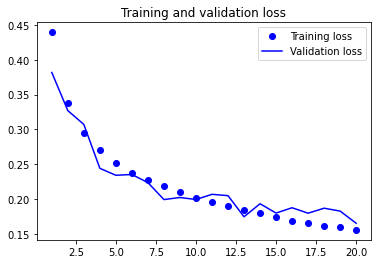

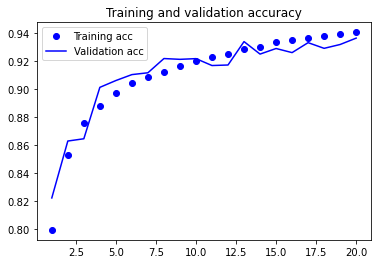

<Figure size 432x288 with 0 Axes>

In [25]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# 4. Validation and Analysis 

* ### Metrics
* ### Prediction and Activation Visualizations
* ### ROC and AUC

In [26]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

16000/16000 [==============================] - 40s 2ms/step


In [27]:
predictions.shape

(16000, 2)

In [28]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

In [29]:
# Put the predictions into a dataframe.
# The columns need to be ordered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()


,no_tumor_tissue,has_tumor_tissue
0,0.951828,0.048172
1,0.819612,0.180388
2,0.740446,0.259554
3,0.994519,0.005481
4,0.777217,0.222783


In [30]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_tumor_tissue']

In [31]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.9827305390625

In [32]:
# Get the labels of the test images.

test_labels = test_gen.classes
test_labels.shape

(16000,)

In [33]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
# Print the label associated with each class
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

In [34]:
from sklearn.metrics import plot_confusion_matrix

In [35]:
# Delete base_dir and it's sub folders to free up disk space.

shutil.rmtree('base_dir')
#[CREATE A TEST FOLDER DIRECTORY STRUCTURE]

# We will be feeding test images from a folder into predict_generator().
# Keras requires that the path should point to a folder containing images and not
# to the images themselves. That is why we are creating a folder (test_images) 
# inside another folder (test_dir).

# test_dir
    # test_images

# create test_dir
test_dir = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)
# check that the directory we created exists
os.listdir('test_dir')

['test_images']

In [36]:
# Transfer the test images into image_dir

test_list = os.listdir('../input/histopathologic-cancer-detection/test')

for image in test_list:
    
    fname = image
    
    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/test', fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
# check that the images are now in the test_images
# Should now be 57458 images in the test_images folder

len(os.listdir('test_dir/test_images'))

57458

In [37]:
test_path ='test_dir'


# Here we change the path to point to the test_images folder.

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [38]:
num_test_images = 57458



predictions = model.predict_generator(test_gen, steps=num_test_images, verbose=1)

57458/57458 [==============================] - 148s 3ms/step


In [39]:
# Are the number of predictions correct?
# Should be 57458.

len(predictions)

57458

In [40]:
# Put the predictions into a dataframe

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.000194,0.999806
1,0.007043,0.992957
2,0.005235,0.994765
3,0.008798,0.991202
4,0.991006,0.008994


In [41]:
# This outputs the file names in the sequence in which 
# the generator processed the test images.
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names
0,0.000194,0.999806,test_images/00006537328c33e284c973d7b39d340809...
1,0.007043,0.992957,test_images/0000ec92553fda4ce39889f9226ace43ca...
2,0.005235,0.994765,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...
3,0.008798,0.991202,test_images/000253dfaa0be9d0d100283b22284ab2f6...
4,0.991006,0.008994,test_images/000270442cc15af719583a8172c87cd2bd...


In [42]:
# Create an id column

# A file name now has this format: 
# test_images/00006537328c33e284c973d7b39d340809f7271b.tif

# This function will extract the id:
# 00006537328c33e284c973d7b39d340809f7271b


def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names,id
0,0.000194,0.999806,test_images/00006537328c33e284c973d7b39d340809...,00006537328c33e284c973d7b39d340809f7271b
1,0.007043,0.992957,test_images/0000ec92553fda4ce39889f9226ace43ca...,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.005235,0.994765,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.008798,0.991202,test_images/000253dfaa0be9d0d100283b22284ab2f6...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.991006,0.008994,test_images/000270442cc15af719583a8172c87cd2bd...,000270442cc15af719583a8172c87cd2bd9c7746


In [43]:
# Get the predicted labels.
# We were asked to predict a probability that the image has tumor tissue
y_pred = df_preds['has_tumor_tissue']

# get the id column
image_id = df_preds['id']

### Confusion Matrix

# 5. Submission

In [44]:
submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')

submission.to_csv('patch_preds.csv', columns=['label']) 
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.999806
0000ec92553fda4ce39889f9226ace43cae3364e,0.992957
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.994765
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.991202
000270442cc15af719583a8172c87cd2bd9c7746,0.008994


In [45]:
# Delete the test_dir directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

shutil.rmtree('test_dir')

# Confusion Matrix

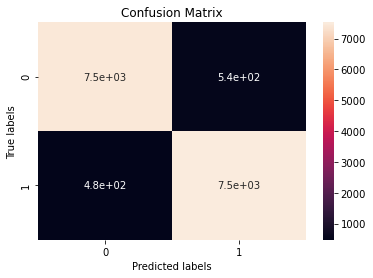

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

## I hope that you found my notebook useful. It took me 2 weeks to analyze the problem and then perform the coding. So, if you enjoyed the notebook, please leave an upvote. Thanks a lot for reading!!